## Run this notebook to get Clone Hero importable output from validation set

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os

DRIVE_PATH = '/content/gdrive/My\ Drive/tensor_hero'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
assert os.path.exists(DRIVE_PYTHON_PATH)

SYM_PATH = '/content/final_project'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [ ]:
import sys
from pathlib import Path
base = Path('/content/drive/My\ Drive/tensor_hero/tensor-hero')
sys.path.append(str(base))
%cd $SYM_PATH/'tensor-hero'

/content/gdrive/My Drive/tensor_hero/tensor-hero


In [ ]:
# Find the training data
cwd = os.getcwd()
print('Current Working Directory: \n{}\n'.format(cwd))

train_path = Path(cwd) / 'fully_curated_colab' / 'train'
val_path = Path(cwd) / 'fully_curated_colab' / 'val'
print('Training Path: \n{}\n'.format(train_path))
print('Validation Path: \n{}\n'.format(val_path))

!ls

Current Working Directory: 
/content/gdrive/My Drive/tensor_hero/tensor-hero

Training Path: 
/content/gdrive/My Drive/tensor_hero/tensor-hero/fully_curated_colab/train

Validation Path: 
/content/gdrive/My Drive/tensor_hero/tensor-hero/fully_curated_colab/val

'CH separated'		  guitar_hero_curated	 runs
 colab_ogg_key_dict.pkl   inference		 separated_colab
'Data Exploration'	  initialization.ipynb	 tensorboard.ipynb
 data_preprocessing	  LICENSE		 tensor_hero
 Documentation		  logs			 tensor_hero_backup
 example_song		  model			 test_key.pkl
 Experiments		  output.png		 Training_Data
 full_curated		  Prototyping		 train_key.pkl
 fully_curated_colab	  README.md		 val_key.pkl
'GH separated'		  requirements.txt


## Check to see what GPU is being utilized

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 23 20:48:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

device: cuda
Loading model weights

Predicting 30 Seconds to Mars - The Kill

predicting segment 0/63


  0%|          | 0/500 [00:00<?, ?it/s]


m1 notes tensor: tensor([[0]], device='cuda:0')
prediction : [0]
prediction shape: (1,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

 17%|█▋        | 87/500 [00:03<00:17, 24.09it/s]


m1 notes tensor: tensor([[  0,  27,   3,  20,  31,   3,  21,  35,   3,  21,  39,   3,  21,  43,
           3,  19,  47,   3,  19,  51,   3,  19,  55,   3,  21,  59,   3,  19,
          63,   3,  21,  67,   3,  19,  71,   3,  21,  75,   3,  19,  79,   3,
          21,  83,   3,  19,  87,   3,  21,  91,   3,  19,  95,   3,  21,  99,
           3,  19, 103,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,  19,
         113,   3,  21, 115,   3,  19, 117,   3,  21, 119,   3,  19, 121,   3,
          21, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  20  31   3  21  35   3  21  39   3  21  43   3  19  47   3
  19  51   3  19  55   3  21  59   3  19  63   3  21  67   3  19  71   3
  21  75   3  19  79   3  21  83   3  19  87   3  21  91   3  19  95   3
  21  99   3  19 103   3  21 107   3  19 109   3  21 111   3  19 113   3
  21 115   3  19 117   3  21 119   3  19 121   3  21 123   3  19]
prediction shape: (88,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 

 15%|█▌        | 75/500 [00:03<00:19, 22.00it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:17, 24.06it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:17, 24.29it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:17, 24.08it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:18, 22.74it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:17, 24.26it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 19%|█▊        | 93/500 [00:04<00:17, 22.96it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  98,
           3,  21, 100,   3,  19, 103,   3,  21, 105,   3,  19, 107,   3,  21,
         109,   3,  19, 111,   3,  21, 113,   3,  19, 115,   3,  21, 117,   3,
          19, 119,   3,  21, 121,   3,  19, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  98   3  21 100   3  19 103   3  21 105   3  19 107   3  21 109   3
  19 111   3  21 113   3  19 115   3  21 117   3  19 119   3  21 121   3
  19 123   3  19]
prediction shape: (94,)
predicted n

 15%|█▌        | 75/500 [00:03<00:18, 23.51it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 20%|██        | 102/500 [00:04<00:16, 23.99it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 15%|█▌        | 75/500 [00:03<00:18, 23.58it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 19%|█▊        | 93/500 [00:03<00:17, 23.53it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 101,   3,  19, 103,   3,  21, 105,   3,  19, 107,   3,  21,
         109,   3,  19, 111,   3,  21, 113,   3,  19, 115,   3,  21, 117,   3,
          19, 119,   3,  21, 121,   3,  19, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 101   3  19 103   3  21 105   3  19 107   3  21 109   3
  19 111   3  21 113   3  19 115   3  21 117   3  19 119   3  21 121   3
  19 123   3  19]
prediction shape: (94,)
predicted n

 16%|█▌        | 81/500 [00:03<00:17, 23.59it/s]


m1 notes tensor: tensor([[  0,  27,   3,  20,  31,   3,  21,  35,   3,  21,  39,   3,  21,  43,
           3,  19,  47,   3,  19,  51,   3,  19,  55,   3,  21,  59,   3,  19,
          63,   3,  21,  67,   3,  19,  71,   3,  21,  75,   3,  19,  79,   3,
          21,  83,   3,  19,  87,   3,  21,  91,   3,  19,  95,   3,  21,  99,
           3,  19, 103,   3,  21, 107,   3,  19, 111,   3,  21, 113,   3,  19,
         116,   3,  21, 119,   3,  19, 121,   3,  21, 123,   3,  19]],
       device='cuda:0')
prediction : [  0  27   3  20  31   3  21  35   3  21  39   3  21  43   3  19  47   3
  19  51   3  19  55   3  21  59   3  19  63   3  21  67   3  19  71   3
  21  75   3  19  79   3  21  83   3  19  87   3  21  91   3  19  95   3
  21  99   3  19 103   3  21 107   3  19 111   3  21 113   3  19 116   3
  21 119   3  19 121   3  21 123   3  19]
prediction shape: (82,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 2. 0. 0. 0. 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:18, 23.37it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:17, 23.81it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 17%|█▋        | 87/500 [00:03<00:17, 23.92it/s]


m1 notes tensor: tensor([[  0,  27,   3,  20,  31,   3,  21,  35,   3,  21,  39,   3,  21,  43,
           3,  19,  47,   3,  19,  51,   3,  19,  55,   3,  21,  59,   3,  19,
          63,   3,  21,  67,   3,  19,  71,   3,  21,  75,   3,  19,  79,   3,
          21,  83,   3,  19,  87,   3,  21,  91,   3,  19,  95,   3,  21,  99,
           3,  19, 103,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,  19,
         113,   3,  21, 115,   3,  19, 117,   3,  21, 119,   3,  19, 121,   3,
          21, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  20  31   3  21  35   3  21  39   3  21  43   3  19  47   3
  19  51   3  19  55   3  21  59   3  19  63   3  21  67   3  19  71   3
  21  75   3  19  79   3  21  83   3  19  87   3  21  91   3  19  95   3
  21  99   3  19 103   3  21 107   3  19 109   3  21 111   3  19 113   3
  21 115   3  19 117   3  21 119   3  19 121   3  21 123   3  19]
prediction shape: (88,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 

 15%|█▌        | 75/500 [00:03<00:18, 23.47it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 19%|█▊        | 93/500 [00:03<00:17, 23.77it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  37,   3,  21,  41,   3,  19,  45,
           3,  21,  49,   3,  21,  53,   3,  19,  57,   3,  19,  61,   3,  21,
          65,   3,  19,  69,   3,  21,  73,   3,  19,  77,   3,  21,  81,   3,
          19,  85,   3,  21,  88,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 101,   3,  19, 103,   3,  21, 105,   3,  19, 107,   3,  21,
         109,   3,  19, 111,   3,  21, 113,   3,  19, 115,   3,  21, 117,   3,
          19, 119,   3,  21, 121,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  37   3  21  41   3  19  45   3  21  49   3
  21  53   3  19  57   3  19  61   3  21  65   3  19  69   3  21  73   3
  19  77   3  21  81   3  19  85   3  21  88   3  19  91   3  21  95   3
  19  99   3  21 101   3  19 103   3  21 105   3  19 107   3  21 109   3
  19 111   3  21 113   3  19 115   3  21 117   3  19 119   3  21 121   3
  19 123   3  21]
prediction shape: (94,)
predicted n

 15%|█▌        | 75/500 [00:03<00:17, 23.84it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:18, 22.80it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 20%|██        | 102/500 [00:04<00:16, 23.87it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:16, 24.18it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:16, 23.79it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|█▉        | 99/500 [00:04<00:16, 23.89it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  98,   3,  21, 100,   3,  19, 103,   3,  21,
         105,   3,  19, 107,   3,  21, 109,   3,  19, 111,   3,  21, 113,   3,
          19, 115,   3,  19, 117,   3,  21, 119,   3,  19, 121,   3,  21, 123,
           3,  19]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  98   3  21 100   3  19 103   3  21 105   3
  19 107   3  21 109   3  19 111   3  21 113   3  19 115   3  19 117   3
  21 119   3  

 20%|██        | 102/500 [00:04<00:17, 22.96it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 15%|█▌        | 75/500 [00:03<00:18, 23.46it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:17, 23.89it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:18, 23.60it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:17, 23.73it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:17, 23.77it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:17, 23.90it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:17, 23.88it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:18, 23.03it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:18, 23.51it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:18, 23.42it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 13%|█▎        | 66/500 [00:02<00:18, 23.15it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 102,   3,  19, 105,   3,  21, 107,   3,  19]],
       device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 102   3  19 105   3  21 107   3  19]
prediction shape: (67,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 2. 0. 0. 0. 0. 0. 0. 0. 

  3%|▎         | 15/500 [00:00<00:21, 22.76it/s]


m1 notes tensor: tensor([[  0,  93,   3,  20,  96,   3,  21,  99,   3,  21, 101,   3,  19, 105,
           3,  19]], device='cuda:0')
prediction : [  0  93   3  20  96   3  21  99   3  21 101   3  19 105   3  19]
prediction shape: (16,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 

  8%|▊         | 42/500 [00:01<00:19, 23.14it/s]


m1 notes tensor: tensor([[  0,  85,   3,  20,  91,   3,  21,  93,   3,  21,  95,   3,  21,  97,
           3,  19,  99,   3,  19, 103,   3,  19, 105,   3,  21, 107,   3,  19,
         111,   3,  21, 113,   3,  19, 115,   3,  21, 119,   3,  19, 121,   3,
          21]], device='cuda:0')
prediction : [  0  85   3  20  91   3  21  93   3  21  95   3  21  97   3  19  99   3
  19 103   3  19 105   3  21 107   3  19 111   3  21 113   3  19 115   3
  21 119   3  19 121   3  21]
prediction shape: (43,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 11%|█▏        | 57/500 [00:02<00:18, 23.44it/s]


m1 notes tensor: tensor([[  0,  85,   3,  20,  87,   3,  21,  91,   3,  21,  93,   3,  19,  95,
           3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21, 103,   3,  19,
         105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,  19, 113,   3,
          21, 115,   3,  19, 117,   3,  21, 119,   3,  19, 121,   3,  21, 123,
           3,  19]], device='cuda:0')
prediction : [  0  85   3  20  87   3  21  91   3  21  93   3  19  95   3  19  97   3
  21  99   3  19 101   3  21 103   3  19 105   3  21 107   3  19 109   3
  21 111   3  19 113   3  21 115   3  19 117   3  21 119   3  19 121   3
  21 123   3  19]
prediction shape: (58,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

 20%|██        | 102/500 [00:04<00:16, 24.18it/s]


m1 notes tensor: tensor([[  0,  27,   3,  20,  31,   3,  21,  35,   3,  21,  39,   3,  21,  43,
           3,  19,  47,   3,  19,  51,   3,  19,  55,   3,  21,  59,   3,  19,
          63,   3,  21,  67,   3,  19,  71,   3,  21,  75,   3,  19,  79,   3,
          21,  83,   3,  19,  86,   3,  21,  88,   3,  19,  91,   3,  21,  93,
           3,  19,  95,   3,  21,  97,   3,  19,  99,   3,  21, 101,   3,  19,
         103,   3,  21, 105,   3,  19, 107,   3,  21, 109,   3,  19, 111,   3,
          21, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  20  31   3  21  35   3  21  39   3  21  43   3  19  47   3
  19  51   3  19  55   3  21  59   3  19  63   3  21  67   3  19  71   3
  21  75   3  19  79   3  21  83   3  19  86   3  21  88   3  19  91   3
  21  93   3  19  95   3  21  97   3  19  99   3  21 101   3  19 103   3
  21 105   3  19 107   3  21 109   3  19 111   3  21 113   3  19 115   3

 15%|█▌        | 75/500 [00:03<00:17, 23.98it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:18, 23.05it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:17, 23.73it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:17, 23.67it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:18, 23.26it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 20%|██        | 102/500 [00:04<00:16, 23.45it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 15%|█▌        | 75/500 [00:03<00:18, 23.31it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:18, 23.17it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:18, 22.45it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 20%|██        | 102/500 [00:04<00:16, 23.59it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:16, 23.91it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 15%|█▌        | 75/500 [00:03<00:18, 23.45it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 15%|█▌        | 75/500 [00:03<00:18, 23.54it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 17%|█▋        | 87/500 [00:03<00:17, 23.58it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 109,   3,  19, 111,   3,  21,
         113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,   3,
          19, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 109   3  19 111   3  21 113   3
  19 115   3  21 117   3  19 119   3  21 121   3  19 123   3  19]
prediction shape: (88,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 

 15%|█▌        | 75/500 [00:03<00:18, 23.43it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 20%|██        | 102/500 [00:04<00:17, 22.77it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 15%|█▌        | 75/500 [00:03<00:17, 23.81it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 20%|██        | 102/500 [00:04<00:16, 23.64it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 15%|█▌        | 75/500 [00:03<00:18, 23.54it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

 20%|██        | 102/500 [00:04<00:16, 23.77it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

  6%|▌         | 30/500 [00:01<00:20, 22.78it/s]


m1 notes tensor: tensor([[ 0, 27,  3, 20, 31,  3, 21, 35,  3, 21, 39,  3, 19, 43,  3, 19, 47,  3,
         21, 51,  3, 19, 55,  3, 21, 59,  3, 19, 63,  3, 21]], device='cuda:0')
prediction : [ 0 27  3 20 31  3 21 35  3 21 39  3 19 43  3 19 47  3 21 51  3 19 55  3
 21 59  3 19 63  3 21]
prediction shape: (31,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.

  0%|          | 0/500 [00:00<?, ?it/s]


m1 notes tensor: tensor([[0]], device='cuda:0')
prediction : [0]
prediction shape: (1,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

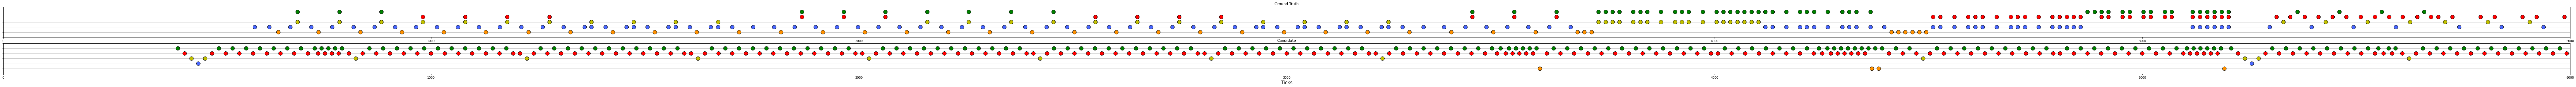


Predicting Backyard Babies - Minus Celsius

predicting segment 0/55


  2%|▏         | 12/500 [00:00<00:22, 21.69it/s]


m1 notes tensor: tensor([[  0,  99,   3,  20, 101,   3,  21, 105,   3,  21, 107,   3,  19]],
       device='cuda:0')
prediction : [  0  99   3  20 101   3  21 105   3  21 107   3  19]
prediction shape: (13,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 20%|██        | 102/500 [00:04<00:17, 22.92it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.35it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 21%|██        | 105/500 [00:04<00:17, 23.00it/s]


m1 notes tensor: tensor([[  0,  51,   3,  20,  57,   3,  21,  59,   3,  21,  61,   3,  21,  63,
           3,  19,  65,   3,  19,  67,   3,  19,  69,   3,  21,  71,   3,  19,
          73,   3,  21,  75,   3,  19,  77,   3,  21,  79,   3,  19,  81,   3,
          21,  83,   3,  19,  85,   3,  21,  87,   3,  19,  89,   3,  21,  91,
           3,  19,  93,   3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19,
         101,   3,  21, 103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,
          21, 111,   3,  19, 113,   3,  21, 115,   3,  19, 117,   3,  21, 119,
           3,  19, 121,   3,  21, 123,   3,  19]], device='cuda:0')
prediction : [  0  51   3  20  57   3  21  59   3  21  61   3  21  63   3  19  65   3
  19  67   3  19  69   3  21  71   3  19  73   3  21  75   3  19  77   3
  21  79   3  19  81   3  21  83   3  19  85   3  21  87   3  19  89   3
  21  91   3  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3
  21 103   3  19 105   3  21 107   3  19 109   3  21 111 

 29%|██▉       | 147/500 [00:06<00:15, 22.96it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  29,   3,  19,  31,   3,  21,  33,   3,  19,  36,
           3,  21,  38,   3,  19,  40,   3,  21,  42,   3,  19,  44,   3,  21,
          46,   3,  19,  48,   3,  21,  50,   3,  19,  52,   3,  21,  53,   3,
          19,  55,   3,  21,  57,   3,  19,  59,   3,  21,  61,   3,  19,  63,
           3,  21,  65,   3,  19,  67,   3,  21,  69,   3,  19,  71,   3,  21,
          73,   3,  19,  75,   3,  21,  77,   3,  19,  79,   3,  21,  81,   3,
          19,  83,   3,  21,  85,   3,  19,  87,   3,  21,  88,   3,  19,  90,
           3,  19,  92,   3,  21,  94,   3,  21,  96,   3,  19,  99,   3,  21,
         101,   3,  19, 103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,
          21, 111,   3,  21, 113,   3,  19, 115,   3,  19, 117,   3,  21, 119,
           3,  19, 121,   3,  21, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  29   3  19  31   3  21  33   3  19  36   3  21  38   3
  19  40   3  21  42   3  19  44   3  2

 29%|██▉       | 147/500 [00:06<00:14, 23.55it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  29,   3,  19,  31,   3,  21,  33,   3,  19,  36,
           3,  21,  38,   3,  19,  40,   3,  21,  42,   3,  19,  44,   3,  21,
          46,   3,  19,  48,   3,  21,  50,   3,  19,  52,   3,  21,  53,   3,
          19,  55,   3,  21,  57,   3,  19,  59,   3,  21,  61,   3,  19,  63,
           3,  21,  65,   3,  19,  67,   3,  21,  69,   3,  19,  71,   3,  21,
          73,   3,  19,  75,   3,  21,  77,   3,  19,  79,   3,  21,  81,   3,
          19,  83,   3,  21,  85,   3,  19,  87,   3,  19,  89,   3,  21,  91,
           3,  19,  93,   3,  21,  95,   3,  21,  97,   3,  19,  99,   3,  21,
         101,   3,  19, 103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,
          21, 111,   3,  21, 113,   3,  19, 115,   3,  19, 117,   3,  19, 119,
           3,  21, 121,   3,  21, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  21  29   3  19  31   3  21  33   3  19  36   3  21  38   3
  19  40   3  21  42   3  19  44   3  2

 16%|█▌        | 78/500 [00:03<00:18, 23.03it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         118,   3,  19, 120,   3,  21, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 118   3
  19 120   3  21 123   3  19]
prediction shape: (79,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.

 19%|█▊        | 93/500 [00:04<00:17, 22.91it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 101,   3,  19, 103,   3,  21, 105,   3,  19, 107,   3,  21,
         109,   3,  19, 111,   3,  21, 113,   3,  19, 115,   3,  21, 117,   3,
          19, 119,   3,  21, 121,   3,  19, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 101   3  19 103   3  21 105   3  19 107   3  21 109   3
  19 111   3  21 113   3  19 115   3  21 117   3  19 119   3  21 121   3
  19 123   3  19]
prediction shape: (94,)
predicted n

 17%|█▋        | 87/500 [00:03<00:18, 22.88it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 109,   3,  19, 111,   3,  21,
         113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,   3,
          19, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 109   3  19 111   3  21 113   3
  19 115   3  21 117   3  19 119   3  21 121   3  19 123   3  19]
prediction shape: (88,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 

 17%|█▋        | 87/500 [00:03<00:17, 23.10it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 109,   3,  19, 111,   3,  21,
         113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,   3,
          19, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 109   3  19 111   3  21 113   3
  19 115   3  21 117   3  19 119   3  21 121   3  19 123   3  19]
prediction shape: (88,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 

 19%|█▊        | 93/500 [00:04<00:17, 23.18it/s]


m1 notes tensor: tensor([[  0,  27,   3,  20,  31,   3,  21,  35,   3,  21,  39,   3,  21,  43,
           3,  19,  47,   3,  19,  51,   3,  19,  55,   3,  21,  59,   3,  19,
          63,   3,  21,  67,   3,  21,  71,   3,  19,  75,   3,  19,  79,   3,
          21,  83,   3,  19,  87,   3,  21,  91,   3,  19,  95,   3,  21,  98,
           3,  19, 100,   3,  21, 102,   3,  19, 104,   3,  21, 107,   3,  19,
         109,   3,  21, 111,   3,  19, 113,   3,  21, 115,   3,  19, 117,   3,
          21, 119,   3,  19, 121,   3,  21, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  20  31   3  21  35   3  21  39   3  21  43   3  19  47   3
  19  51   3  19  55   3  21  59   3  19  63   3  21  67   3  21  71   3
  19  75   3  19  79   3  21  83   3  19  87   3  21  91   3  19  95   3
  21  98   3  19 100   3  21 102   3  19 104   3  21 107   3  19 109   3
  21 111   3  19 113   3  21 115   3  19 117   3  21 119   3  19 121   3
  21 123   3  19]
prediction shape: (94,)
predicted n

 19%|█▊        | 93/500 [00:04<00:17, 23.09it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  21,  35,   3,  19,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  98,
           3,  21, 100,   3,  19, 103,   3,  21, 105,   3,  19, 107,   3,  21,
         109,   3,  19, 111,   3,  21, 113,   3,  19, 115,   3,  21, 117,   3,
          19, 119,   3,  21, 121,   3,  19, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  21  31   3  21  35   3  19  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  98   3  21 100   3  19 103   3  21 105   3  19 107   3  21 109   3
  19 111   3  21 113   3  19 115   3  21 117   3  19 119   3  21 121   3
  19 123   3  19]
prediction shape: (94,)
predicted n

 29%|██▉       | 147/500 [00:06<00:15, 22.83it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  29,   3,  19,  31,   3,  21,  33,   3,  19,  36,
           3,  21,  38,   3,  19,  40,   3,  21,  42,   3,  19,  44,   3,  21,
          46,   3,  19,  48,   3,  21,  50,   3,  19,  52,   3,  21,  53,   3,
          19,  55,   3,  21,  57,   3,  19,  59,   3,  21,  61,   3,  19,  63,
           3,  21,  65,   3,  19,  67,   3,  21,  69,   3,  19,  71,   3,  21,
          73,   3,  19,  75,   3,  21,  77,   3,  19,  79,   3,  21,  81,   3,
          19,  83,   3,  21,  85,   3,  19,  87,   3,  19,  89,   3,  21,  91,
           3,  19,  93,   3,  21,  95,   3,  21,  97,   3,  19,  99,   3,  21,
         101,   3,  19, 103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,
          21, 111,   3,  21, 113,   3,  19, 115,   3,  19, 117,   3,  19, 119,
           3,  19, 121,   3,  21, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  29   3  19  31   3  21  33   3  19  36   3  21  38   3
  19  40   3  21  42   3  19  44   3  2

 20%|██        | 102/500 [00:04<00:17, 23.33it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.05it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 23.10it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.15it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 22.69it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 23.27it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:16, 23.58it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 16%|█▌        | 81/500 [00:03<00:17, 23.38it/s]


m1 notes tensor: tensor([[  0,  27,   3,  20,  31,   3,  21,  35,   3,  21,  39,   3,  21,  43,
           3,  19,  47,   3,  19,  51,   3,  19,  55,   3,  21,  59,   3,  19,
          63,   3,  21,  67,   3,  19,  71,   3,  21,  75,   3,  19,  79,   3,
          21,  83,   3,  19,  87,   3,  21,  91,   3,  19,  95,   3,  21,  99,
           3,  19, 103,   3,  21, 107,   3,  19, 110,   3,  21, 113,   3,  19,
         116,   3,  21, 119,   3,  19, 121,   3,  21, 123,   3,  19]],
       device='cuda:0')
prediction : [  0  27   3  20  31   3  21  35   3  21  39   3  21  43   3  19  47   3
  19  51   3  19  55   3  21  59   3  19  63   3  21  67   3  19  71   3
  21  75   3  19  79   3  21  83   3  19  87   3  21  91   3  19  95   3
  21  99   3  19 103   3  21 107   3  19 110   3  21 113   3  19 116   3
  21 119   3  19 121   3  21 123   3  19]
prediction shape: (82,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 2. 0. 0. 0. 0. 0. 0. 0. 0

 20%|█▉        | 99/500 [00:04<00:17, 23.04it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  98,   3,  21, 100,   3,  19, 102,   3,  21,
         104,   3,  19, 107,   3,  21, 109,   3,  19, 111,   3,  21, 113,   3,
          19, 115,   3,  19, 117,   3,  21, 119,   3,  19, 121,   3,  21, 123,
           3,  19]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  98   3  21 100   3  19 102   3  21 104   3
  19 107   3  21 109   3  19 111   3  21 113   3  19 115   3  19 117   3
  21 119   3  

 17%|█▋        | 87/500 [00:03<00:17, 23.11it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 109,   3,  19, 111,   3,  21,
         113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,   3,
          19, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 109   3  19 111   3  21 113   3
  19 115   3  21 117   3  19 119   3  21 121   3  19 123   3  19]
prediction shape: (88,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 

 20%|██        | 102/500 [00:04<00:17, 22.95it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.05it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.27it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.18it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.37it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.30it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 22.77it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.04it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.09it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.03it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.34it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.19it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 22.76it/s]


m1 notes tensor: tensor([[  0,  27,   3,  20,  31,   3,  21,  35,   3,  21,  39,   3,  21,  43,
           3,  19,  47,   3,  19,  51,   3,  19,  55,   3,  21,  59,   3,  19,
          63,   3,  21,  67,   3,  19,  71,   3,  21,  75,   3,  19,  79,   3,
          21,  83,   3,  19,  86,   3,  21,  88,   3,  19,  91,   3,  21,  93,
           3,  19,  95,   3,  21,  97,   3,  19,  99,   3,  21, 101,   3,  19,
         103,   3,  21, 105,   3,  19, 107,   3,  21, 109,   3,  19, 111,   3,
          21, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  20  31   3  21  35   3  21  39   3  21  43   3  19  47   3
  19  51   3  19  55   3  21  59   3  19  63   3  21  67   3  19  71   3
  21  75   3  19  79   3  21  83   3  19  86   3  21  88   3  19  91   3
  21  93   3  19  95   3  21  97   3  19  99   3  21 101   3  19 103   3
  21 105   3  19 107   3  21 109   3  19 111   3  21 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 22.90it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 29%|██▉       | 147/500 [00:06<00:15, 23.35it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  29,   3,  19,  31,   3,  21,  33,   3,  19,  36,
           3,  21,  38,   3,  19,  40,   3,  21,  42,   3,  19,  44,   3,  21,
          46,   3,  19,  48,   3,  21,  50,   3,  19,  52,   3,  21,  53,   3,
          19,  55,   3,  21,  57,   3,  19,  59,   3,  21,  61,   3,  19,  63,
           3,  21,  65,   3,  19,  67,   3,  21,  69,   3,  19,  71,   3,  21,
          73,   3,  19,  75,   3,  21,  77,   3,  19,  79,   3,  21,  81,   3,
          19,  83,   3,  21,  85,   3,  19,  87,   3,  19,  89,   3,  21,  91,
           3,  19,  93,   3,  21,  95,   3,  21,  97,   3,  19,  99,   3,  21,
         101,   3,  19, 103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,
          21, 111,   3,  21, 113,   3,  19, 115,   3,  19, 117,   3,  19, 119,
           3,  19, 121,   3,  21, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  29   3  19  31   3  21  33   3  19  36   3  21  38   3
  19  40   3  21  42   3  19  44   3  2

 29%|██▉       | 147/500 [00:06<00:15, 23.45it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  29,   3,  19,  31,   3,  21,  33,   3,  19,  36,
           3,  21,  38,   3,  19,  40,   3,  21,  42,   3,  19,  44,   3,  21,
          46,   3,  19,  48,   3,  21,  50,   3,  19,  52,   3,  21,  53,   3,
          19,  55,   3,  21,  57,   3,  19,  59,   3,  21,  61,   3,  19,  63,
           3,  21,  65,   3,  19,  67,   3,  21,  69,   3,  19,  71,   3,  21,
          73,   3,  19,  75,   3,  21,  77,   3,  19,  79,   3,  21,  81,   3,
          19,  83,   3,  21,  85,   3,  19,  87,   3,  19,  89,   3,  21,  91,
           3,  19,  93,   3,  21,  95,   3,  21,  97,   3,  19,  99,   3,  21,
         101,   3,  19, 103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,
          21, 111,   3,  21, 113,   3,  19, 115,   3,  19, 117,   3,  19, 119,
           3,  19, 121,   3,  21, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  29   3  19  31   3  21  33   3  19  36   3  21  38   3
  19  40   3  21  42   3  19  44   3  2

 20%|██        | 102/500 [00:04<00:17, 23.19it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 29%|██▉       | 147/500 [00:06<00:15, 23.00it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  29,   3,  19,  31,   3,  21,  33,   3,  19,  36,
           3,  21,  38,   3,  19,  40,   3,  21,  42,   3,  19,  44,   3,  21,
          46,   3,  19,  48,   3,  21,  50,   3,  19,  52,   3,  21,  53,   3,
          19,  55,   3,  21,  57,   3,  19,  59,   3,  21,  61,   3,  19,  63,
           3,  21,  65,   3,  19,  67,   3,  21,  69,   3,  19,  71,   3,  21,
          73,   3,  19,  75,   3,  21,  77,   3,  19,  79,   3,  21,  81,   3,
          19,  83,   3,  21,  85,   3,  19,  87,   3,  19,  89,   3,  21,  91,
           3,  19,  93,   3,  21,  95,   3,  21,  97,   3,  19,  99,   3,  21,
         101,   3,  19, 103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,
          21, 111,   3,  21, 113,   3,  19, 115,   3,  19, 117,   3,  19, 119,
           3,  19, 121,   3,  21, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  29   3  19  31   3  21  33   3  19  36   3  21  38   3
  19  40   3  21  42   3  19  44   3  2

 29%|██▉       | 147/500 [00:06<00:14, 23.57it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  29,   3,  19,  31,   3,  21,  33,   3,  19,  36,
           3,  21,  38,   3,  19,  40,   3,  21,  42,   3,  19,  44,   3,  21,
          46,   3,  19,  48,   3,  21,  50,   3,  19,  52,   3,  21,  53,   3,
          19,  55,   3,  21,  57,   3,  19,  59,   3,  21,  61,   3,  19,  63,
           3,  21,  65,   3,  19,  67,   3,  21,  69,   3,  19,  71,   3,  21,
          73,   3,  19,  75,   3,  21,  77,   3,  19,  79,   3,  21,  81,   3,
          19,  83,   3,  21,  85,   3,  19,  87,   3,  19,  89,   3,  21,  91,
           3,  19,  93,   3,  21,  95,   3,  21,  97,   3,  19,  99,   3,  21,
         101,   3,  19, 103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,
          21, 111,   3,  21, 113,   3,  19, 115,   3,  19, 117,   3,  19, 119,
           3,  19, 121,   3,  21, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  29   3  19  31   3  21  33   3  19  36   3  21  38   3
  19  40   3  21  42   3  19  44   3  2

 29%|██▉       | 147/500 [00:06<00:15, 23.00it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  29,   3,  19,  31,   3,  21,  33,   3,  19,  36,
           3,  21,  38,   3,  19,  40,   3,  21,  42,   3,  19,  44,   3,  21,
          46,   3,  19,  48,   3,  21,  50,   3,  19,  52,   3,  21,  53,   3,
          19,  55,   3,  21,  57,   3,  19,  59,   3,  21,  61,   3,  19,  63,
           3,  21,  65,   3,  19,  67,   3,  21,  69,   3,  19,  71,   3,  21,
          73,   3,  19,  75,   3,  21,  77,   3,  19,  79,   3,  21,  81,   3,
          19,  83,   3,  21,  85,   3,  19,  87,   3,  19,  89,   3,  21,  91,
           3,  19,  93,   3,  21,  95,   3,  21,  97,   3,  19,  99,   3,  21,
         101,   3,  19, 103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,
          21, 111,   3,  21, 113,   3,  19, 115,   3,  19, 117,   3,  19, 119,
           3,  19, 121,   3,  21, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  29   3  19  31   3  21  33   3  19  36   3  21  38   3
  19  40   3  21  42   3  19  44   3  2

 29%|██▉       | 147/500 [00:06<00:15, 23.30it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  29,   3,  19,  31,   3,  21,  33,   3,  19,  36,
           3,  21,  38,   3,  19,  40,   3,  21,  42,   3,  19,  44,   3,  21,
          46,   3,  19,  48,   3,  21,  50,   3,  19,  52,   3,  21,  53,   3,
          19,  55,   3,  21,  57,   3,  19,  59,   3,  21,  61,   3,  19,  63,
           3,  21,  65,   3,  19,  67,   3,  21,  69,   3,  19,  71,   3,  21,
          73,   3,  19,  75,   3,  21,  77,   3,  19,  79,   3,  21,  81,   3,
          19,  83,   3,  21,  85,   3,  19,  87,   3,  19,  89,   3,  21,  91,
           3,  19,  93,   3,  21,  95,   3,  21,  97,   3,  19,  99,   3,  21,
         101,   3,  19, 103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,
          21, 111,   3,  21, 113,   3,  19, 115,   3,  19, 117,   3,  19, 119,
           3,  19, 121,   3,  21, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  29   3  19  31   3  21  33   3  19  36   3  21  38   3
  19  40   3  21  42   3  19  44   3  2

 20%|██        | 102/500 [00:04<00:17, 23.41it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 23.28it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:16, 23.56it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 23.34it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 23.15it/s]


m1 notes tensor: tensor([[  0,  45,   3,  20,  49,   3,  21,  53,   3,  21,  57,   3,  21,  61,
           3,  19,  63,   3,  19,  65,   3,  19,  69,   3,  21,  73,   3,  19,
          75,   3,  21,  77,   3,  19,  79,   3,  21,  81,   3,  19,  83,   3,
          21,  85,   3,  19,  87,   3,  21,  89,   3,  19,  91,   3,  21,  93,
           3,  19,  95,   3,  21,  97,   3,  19,  99,   3,  21, 100,   3,  19,
         102,   3,  21, 104,   3,  19, 107,   3,  21, 109,   3,  19, 111,   3,
          21, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  45   3  20  49   3  21  53   3  21  57   3  21  61   3  19  63   3
  19  65   3  19  69   3  21  73   3  19  75   3  21  77   3  19  79   3
  21  81   3  19  83   3  21  85   3  19  87   3  21  89   3  19  91   3
  21  93   3  19  95   3  21  97   3  19  99   3  21 100   3  19 102   3
  21 104   3  19 107   3  21 109   3  19 111   3  21 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 22.98it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 22.62it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.02it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 29%|██▉       | 147/500 [00:06<00:15, 23.18it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  29,   3,  19,  31,   3,  21,  33,   3,  19,  35,
           3,  21,  37,   3,  19,  39,   3,  21,  41,   3,  19,  43,   3,  21,
          45,   3,  19,  47,   3,  21,  49,   3,  19,  51,   3,  21,  53,   3,
          19,  55,   3,  21,  57,   3,  19,  59,   3,  21,  61,   3,  19,  63,
           3,  21,  65,   3,  19,  67,   3,  21,  69,   3,  19,  71,   3,  21,
          73,   3,  19,  75,   3,  21,  77,   3,  19,  79,   3,  21,  81,   3,
          19,  83,   3,  21,  85,   3,  19,  87,   3,  19,  89,   3,  21,  91,
           3,  19,  93,   3,  21,  95,   3,  21,  97,   3,  19,  99,   3,  21,
         101,   3,  19, 103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,
          21, 111,   3,  19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,
           3,  21, 121,   3,  21, 123,   3,  19]], device='cuda:0')
prediction : [  0  27   3  21  29   3  19  31   3  21  33   3  19  35   3  21  37   3
  19  39   3  21  41   3  19  43   3  2

 15%|█▌        | 75/500 [00:03<00:18, 23.06it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  21,  51,   3,  19,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  87,   3,  19,  91,   3,  21,  95,   3,  19,  99,
           3,  21, 103,   3,  19, 107,   3,  21, 111,   3,  19, 115,   3,  21,
         119,   3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  21  51   3  19  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  87   3  19  91   3  21  95   3
  19  99   3  21 103   3  19 107   3  21 111   3  19 115   3  21 119   3
  19 123   3  21]
prediction shape: (76,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

  0%|          | 0/500 [00:00<?, ?it/s]


m1 notes tensor: tensor([[0]], device='cuda:0')
prediction : [0]
prediction shape: (1,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

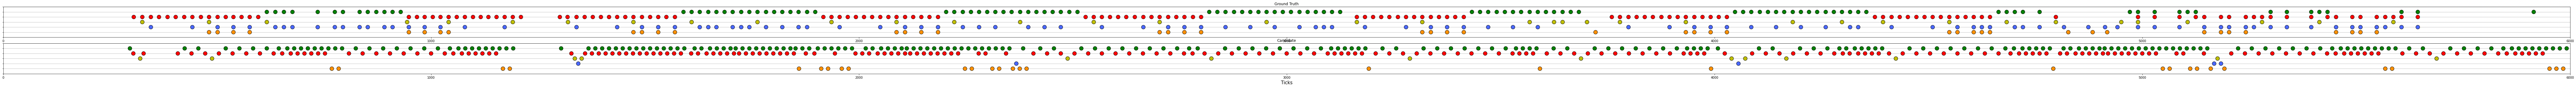


Predicting Behold..

predicting segment 0/18


 13%|█▎        | 66/500 [00:02<00:19, 22.72it/s]


m1 notes tensor: tensor([[  0,  75,   3,  20,  79,   3,  21,  83,   3,  21,  85,   3,  19,  87,
           3,  19,  89,   3,  21,  93,   3,  19,  95,   3,  21,  97,   3,  19,
          99,   3,  21, 101,   3,  19, 103,   3,  21, 105,   3,  19, 107,   3,
          21, 109,   3,  19, 111,   3,  21, 113,   3,  19, 115,   3,  21, 117,
           3,  19, 119,   3,  21, 121,   3,  19, 123,   3,  21]],
       device='cuda:0')
prediction : [  0  75   3  20  79   3  21  83   3  21  85   3  19  87   3  19  89   3
  21  93   3  19  95   3  21  97   3  19  99   3  21 101   3  19 103   3
  21 105   3  19 107   3  21 109   3  19 111   3  21 113   3  19 115   3
  21 117   3  19 119   3  21 121   3  19 123   3  21]
prediction shape: (67,)
predicted notes array:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 

 20%|██        | 102/500 [00:04<00:17, 22.35it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 22.88it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 22.50it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 23.07it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 22.74it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 22.76it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 22.15it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 29%|██▉       | 147/500 [00:06<00:15, 22.58it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  29,   3,  19,  31,   3,  21,  33,   3,  19,  36,
           3,  21,  38,   3,  19,  40,   3,  21,  42,   3,  19,  44,   3,  21,
          46,   3,  19,  48,   3,  21,  50,   3,  19,  52,   3,  21,  53,   3,
          19,  55,   3,  21,  57,   3,  19,  59,   3,  21,  61,   3,  19,  63,
           3,  21,  65,   3,  19,  67,   3,  21,  69,   3,  19,  71,   3,  21,
          73,   3,  19,  75,   3,  21,  77,   3,  19,  79,   3,  21,  81,   3,
          19,  83,   3,  21,  85,   3,  19,  87,   3,  19,  89,   3,  21,  91,
           3,  19,  93,   3,  21,  95,   3,  21,  97,   3,  19,  99,   3,  21,
         101,   3,  19, 103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,
          21, 111,   3,  21, 113,   3,  19, 115,   3,  19, 117,   3,  19, 119,
           3,  19, 121,   3,  21, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  29   3  19  31   3  21  33   3  19  36   3  21  38   3
  19  40   3  21  42   3  19  44   3  2

 20%|██        | 102/500 [00:04<00:17, 22.15it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 22.83it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 22.66it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  19, 115,   3,  21, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  19 115   3

 20%|██        | 102/500 [00:04<00:17, 22.59it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 20%|██        | 102/500 [00:04<00:17, 22.78it/s]


m1 notes tensor: tensor([[  0,  27,   3,  21,  31,   3,  19,  35,   3,  21,  39,   3,  19,  43,
           3,  21,  47,   3,  19,  51,   3,  21,  55,   3,  19,  59,   3,  21,
          63,   3,  19,  67,   3,  21,  71,   3,  19,  75,   3,  21,  79,   3,
          19,  83,   3,  21,  86,   3,  19,  88,   3,  21,  91,   3,  19,  93,
           3,  21,  95,   3,  19,  97,   3,  21,  99,   3,  19, 101,   3,  21,
         103,   3,  19, 105,   3,  21, 107,   3,  19, 109,   3,  21, 111,   3,
          19, 113,   3,  21, 115,   3,  19, 117,   3,  19, 119,   3,  21, 121,
           3,  19, 123,   3,  21]], device='cuda:0')
prediction : [  0  27   3  21  31   3  19  35   3  21  39   3  19  43   3  21  47   3
  19  51   3  21  55   3  19  59   3  21  63   3  19  67   3  21  71   3
  19  75   3  21  79   3  19  83   3  21  86   3  19  88   3  21  91   3
  19  93   3  21  95   3  19  97   3  21  99   3  19 101   3  21 103   3
  19 105   3  21 107   3  19 109   3  21 111   3  19 113   3  21 115   3

 11%|█         | 55/500 [00:02<00:19, 22.93it/s]


KeyboardInterrupt: ignored

In [ ]:
from tensor_hero.inference import full_song_prediction_onset
from tensor_hero.model import OnsetTransformer
from tensor_hero.visualization import plot_chart, slice_notes
from tensor_hero.preprocessing.chart import chart2tensor
from tensor_hero.preprocessing.data import __remove_modifiers, __remove_release_keys
import torch
import pickle

MODEL_NAME = 'o4'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

# Load params
params = Path.cwd() / 'model' / 'saved_models' / MODEL_NAME / 'params.pkl'
with open (params, 'rb') as f:
  params = pickle.load(f)

# Define model
model = OnsetTransformer(
    embedding_size = params['embedding_size'],
    trg_vocab_size = params['trg_vocab_size'],
    num_heads = params['num_heads'],
    num_encoder_layers = params['num_encoder_layers'],
    num_decoder_layers = params['num_decoder_layers'],
    forward_expansion = params['embedding_size']*params['forward_expansion'],
    dropout = params['dropout'],
    max_len = params['max_src_len'],
    device = device
).to(device)

# Load weights into model
print('Loading model weights')
model_weights = Path.cwd() / 'model' / 'saved_models' / MODEL_NAME / (MODEL_NAME + '.pt')
model.load_state_dict(torch.load(str(model_weights)))

# Get list of validation songs
val_dir = Path.cwd() / 'model' / 'validation_output' / 'raw_val'
raw_paths = [val_dir / x for x in os.listdir(val_dir)]

# Create folder to hold output
if not os.path.exists(val_dir.parent / 'model_output' / MODEL_NAME):
  os.mkdir(val_dir.parent / 'model_output' / MODEL_NAME)

# Loop through validation songs, getting model output and plots along the way
for song_dir in raw_paths:
  print(f'\nPredicting {song_dir.parts[-1]}\n')
  # Create song metadata and define outfolder
  song_name = 'TH model ' + MODEL_NAME + ': ' + song_dir.parts[-1]
  song_metadata = {'Name' : song_name,
                'Artist' : 'TH_'+MODEL_NAME,
                'Charter' : 'tensorhero',
                'Offset' : 0,
                'Resolution' : 192,
                'Genre' : 'electronic',
                'MediaType' : 'cd',
                'MusicStream' : 'other.wav'}
  outfolder = val_dir.parent / 'model_output' / MODEL_NAME / song_dir.parts[-1]

  # Predict song
  predicted_notes_array = full_song_prediction_onset(song_path=song_dir / 'other.wav',
                                                     model=model,
                                                     device=device,
                                                     sos_idx=0,
                                                     eos_idx=1,
                                                     max_len=params['max_src_len'],
                                                     song_metadata=song_metadata,
                                                     outfolder=outfolder,
                                                     PRINT=True,
                                                     contour_encoded=True)
  
  # Print first 60 seconds of output compared to ground truth
  gt_notes_array = chart2tensor(song_dir / 'notes.chart')  # convert from chart to simplified notes array
  gt_notes_array = __remove_release_keys(gt_notes_array)
  gt_notes_array = __remove_modifiers(gt_notes_array)
  _ = plot_chart(ground_truth=gt_notes_array[:6000], candidate=predicted_notes_array[:6000])

